<a href="https://www.kaggle.com/code/brmil07/time-series-forecasting?scriptVersionId=159512926" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Time Series Forecasting**
---

Time series forecasting is the study of predicting future values of a time-dependent variable using past measurements. It is the act of using past data to forecast future values in a time-ordered sequence. Time series forecasting is used in a variety of fields including finance, economics, weather forecasting, stock market analysis, demand planning, and many more. This notebook aims to predict the number of product sold in specific country using LSTM algorithm on a given timeseries dataset


The dataset consist of sales for 4 items from two competing stores located in six different countries. The aim is to predict the future sales of this dataset.This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc.

In [1]:
# Install the scalecast library at the begininng
!pip install scalecast --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Obtaining dependency information for scikit-learn>=1.3.1 from https://files.pythonhosted.org/packages/73/b9/3cb1d6aa07d10c66d8ab6d990163e973b3d29a945418058104affad3d4b6/scikit_learn-1.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
  Obtaining dependency information for seaborn>=0.13.0 from https://files.pythonhosted.org/packages/2d/46/cf3fce41ffc543b6e94dadbe6b647559d591df446ec716e72c3b4ce71b34/seaborn-0.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 49

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from scalecast.Forecaster import Forecaster

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

train=pd.read_csv("/kaggle/input/tabular-playground-series-sep-2022/train.csv")
test=pd.read_csv("/kaggle/input/tabular-playground-series-sep-2022/test.csv")

In [3]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=train,x='date',y='num_sold',hue='country')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

# **Exploratory Data Analysis**
---

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [5]:
train.head(10)

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
5,5,2017-01-01,Belgium,KaggleRama,Kaggle Getting Started,187
6,6,2017-01-01,Belgium,KaggleRama,Kaggle Recipe Book,158
7,7,2017-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,267
8,8,2017-01-01,France,KaggleMart,Kaggle Advanced Techniques,610
9,9,2017-01-01,France,KaggleMart,Kaggle Getting Started,463


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,70128.0,35063.500000,20244.354176,0.0,17531.75,35063.5,52595.25,70127.0
num_sold,70128.0,194.296986,126.893874,19.0,95.00,148.0,283.00,986.0


In [7]:
df_train = train.copy()
# Convert the 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Extract the year from the 'date' column
df_train['year'] = df_train['date'].dt.year

In [8]:
# Create a new DataFrame with the average num_sold per year per country
avg_sales_per_year = df_train.groupby(['year', 'country'])['num_sold'].mean().reset_index()
avg_sales_per_year.head(10)

,year,country,num_sold
0,2017,Belgium,233.321575
1,2017,France,204.921233
2,2017,Germany,234.840411
3,2017,Italy,170.913356
4,2017,Poland,73.261301
5,2017,Spain,148.551370
6,2018,Belgium,256.648630
7,2018,France,224.668836
8,2018,Germany,257.512329
9,2018,Italy,186.871233


In [9]:
sum_sales_per_store = df_train.groupby(['store'])['num_sold'].sum().reset_index()
sum_sales_per_store.head(10)

,store,num_sold
0,KaggleMart,10117254
1,KaggleRama,3508405


In [10]:
# Create a new DataFrame with the average num_sold per year per country
sum_sales_per_product = df_train.groupby(['year', 'product'])['num_sold'].sum().reset_index()
sum_sales_per_product.head(10)

,year,product,num_sold
0,2017,Kaggle Advanced Techniques,904253
1,2017,Kaggle Getting Started,722422
2,2017,Kaggle Recipe Book,541478
3,2017,Kaggle for Kids: One Smart Goose,944010
4,2018,Kaggle Advanced Techniques,976711
5,2018,Kaggle Getting Started,780241
6,2018,Kaggle Recipe Book,584303
7,2018,Kaggle for Kids: One Smart Goose,1084169
8,2019,Kaggle Advanced Techniques,940764
9,2019,Kaggle Getting Started,751269


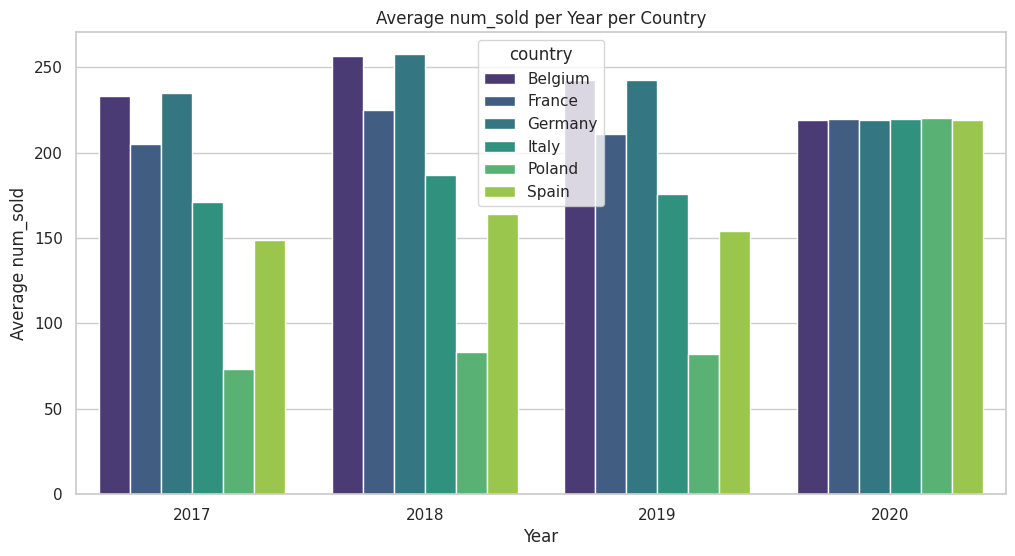

In [11]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot the average num_sold per year per country using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='num_sold', hue='country', data=avg_sales_per_year, palette='viridis')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Average num_sold')
plt.title('Average num_sold per Year per Country')

# Show the plot
plt.show()

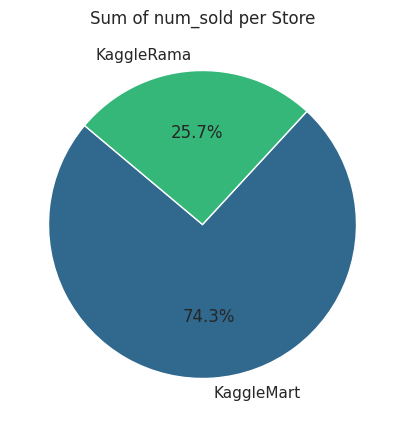

In [12]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a color palette with a unique color for each store
colors = sns.color_palette('viridis', n_colors=len(sum_sales_per_store))

# Plot the pie chart using Seaborn
plt.figure(figsize=(5, 5))
plt.pie(sum_sales_per_store['num_sold'], labels=sum_sales_per_store['store'], autopct='%1.1f%%', startangle=140, colors=colors)

# Set plot labels and title
plt.title('Sum of num_sold per Store')

# Show the plot
plt.show()

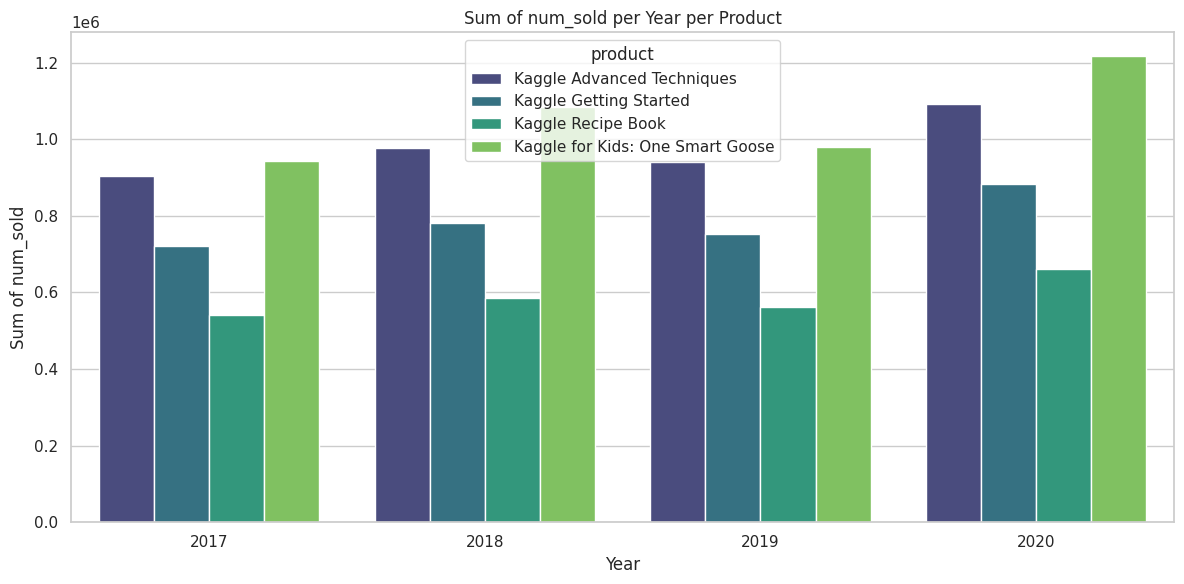

In [13]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot the average num_sold per year per country using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='num_sold', hue='product', data=sum_sales_per_product, palette='viridis')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Sum of num_sold')
plt.title('Sum of num_sold per Year per Product')

# Tweak spacing to prevent clipping of ylabel
plt.tight_layout()
# Show the plot
plt.show()

In [14]:
unique_values_list = train['country'].unique().tolist()
unique_values_df = pd.DataFrame({'Country': train['country'].unique()})
print(unique_values_list)

['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain']


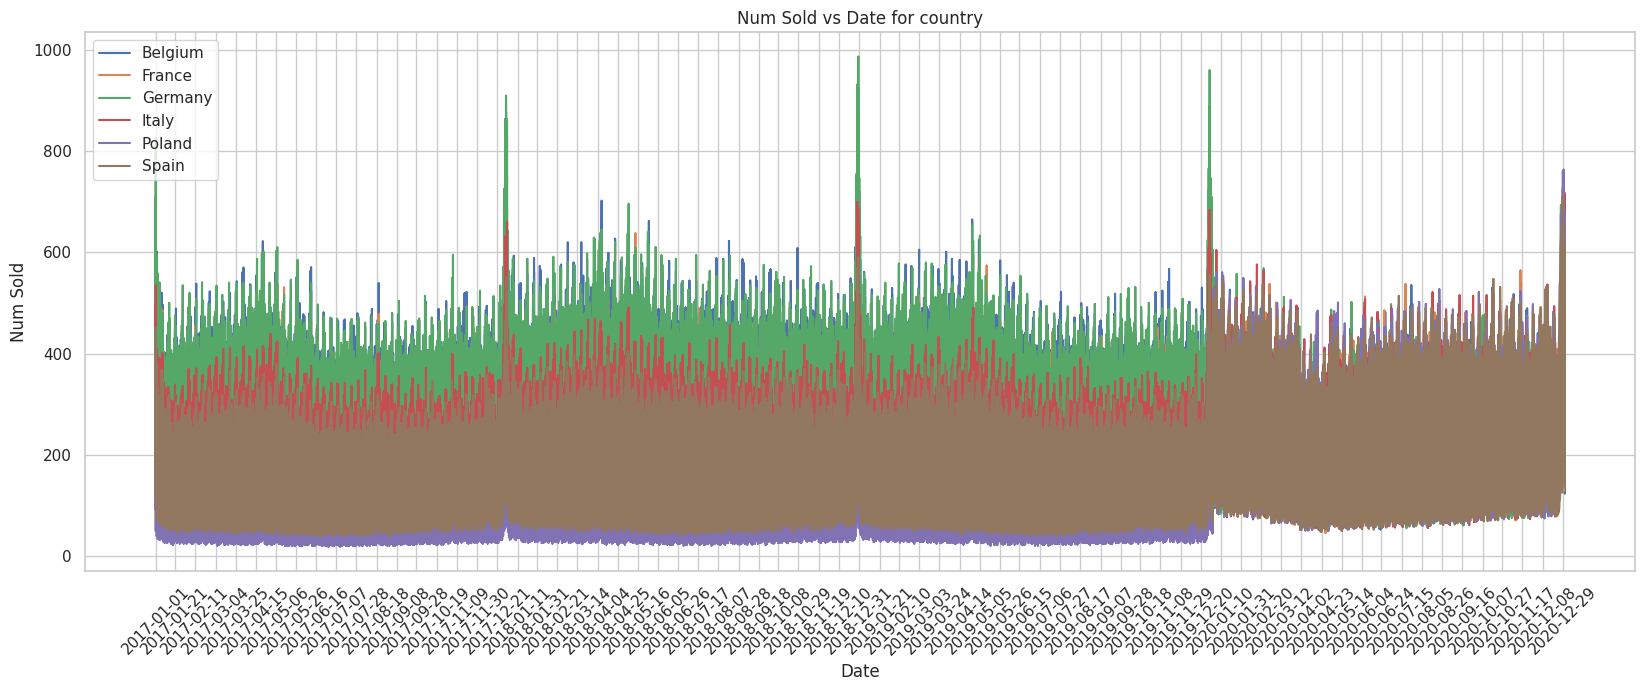

In [15]:
# Filter data for product
belgium = train[train['country'] == 'Belgium']
france = train[train['country'] == 'France']
germany = train[train['country'] == 'Germany']
italy = train[train['country'] == 'Italy']
poland = train[train['country'] == 'Poland']
spain = train[train['country'] == 'Spain']

# Plotting the data
plt.figure(figsize=(20, 7))

plt.plot(belgium['date'], belgium['num_sold'], label='Belgium')
plt.plot(france['date'], france['num_sold'], label='France')
plt.plot(germany['date'], germany['num_sold'], label='Germany')
plt.plot(italy['date'], italy['num_sold'], label='Italy')
plt.plot(poland['date'], poland['num_sold'], label='Poland')
plt.plot(spain['date'], spain['num_sold'], label='Spain')

plt.title('Num Sold vs Date for country')
plt.xlabel('Date')
plt.ylabel('Num Sold')

n = 1000  # Change this value according to your preference
plt.xticks(train['date'][::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

In [16]:
df = train[(train['country']=='Belgium')]

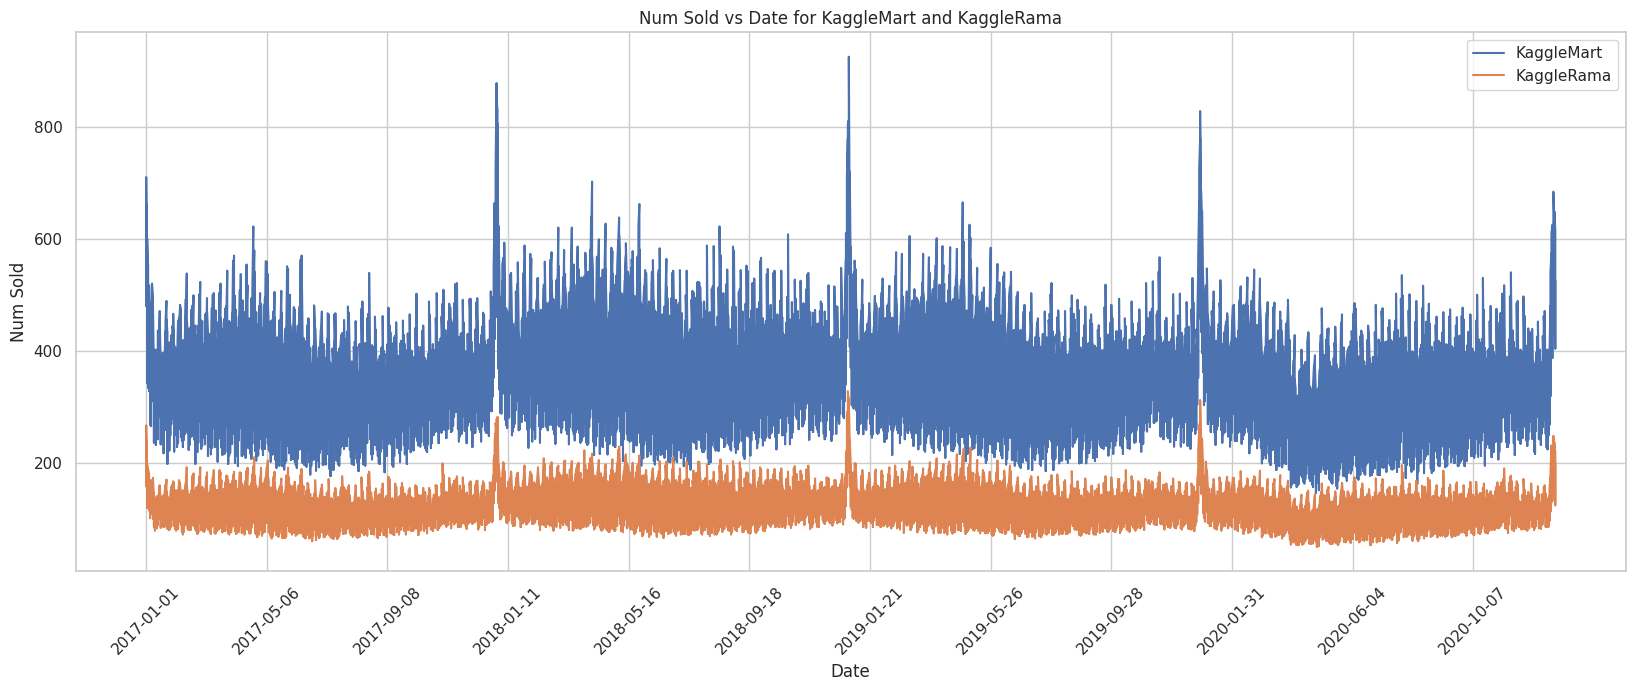

In [17]:
# Filter data for KaggleMart and KaggleRama
kaggle_mart_data = df[df['store'] == 'KaggleMart']
kaggle_rama_data = df[df['store'] == 'KaggleRama']

# Plotting the data
plt.figure(figsize=(20, 7))

plt.plot(kaggle_mart_data['date'], kaggle_mart_data['num_sold'], label='KaggleMart')
plt.plot(kaggle_rama_data['date'], kaggle_rama_data['num_sold'], label='KaggleRama')

plt.title('Num Sold vs Date for KaggleMart and KaggleRama')
plt.xlabel('Date')
plt.ylabel('Num Sold')

n = 1000  # Change this value according to your preference
plt.xticks(df['date'][::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

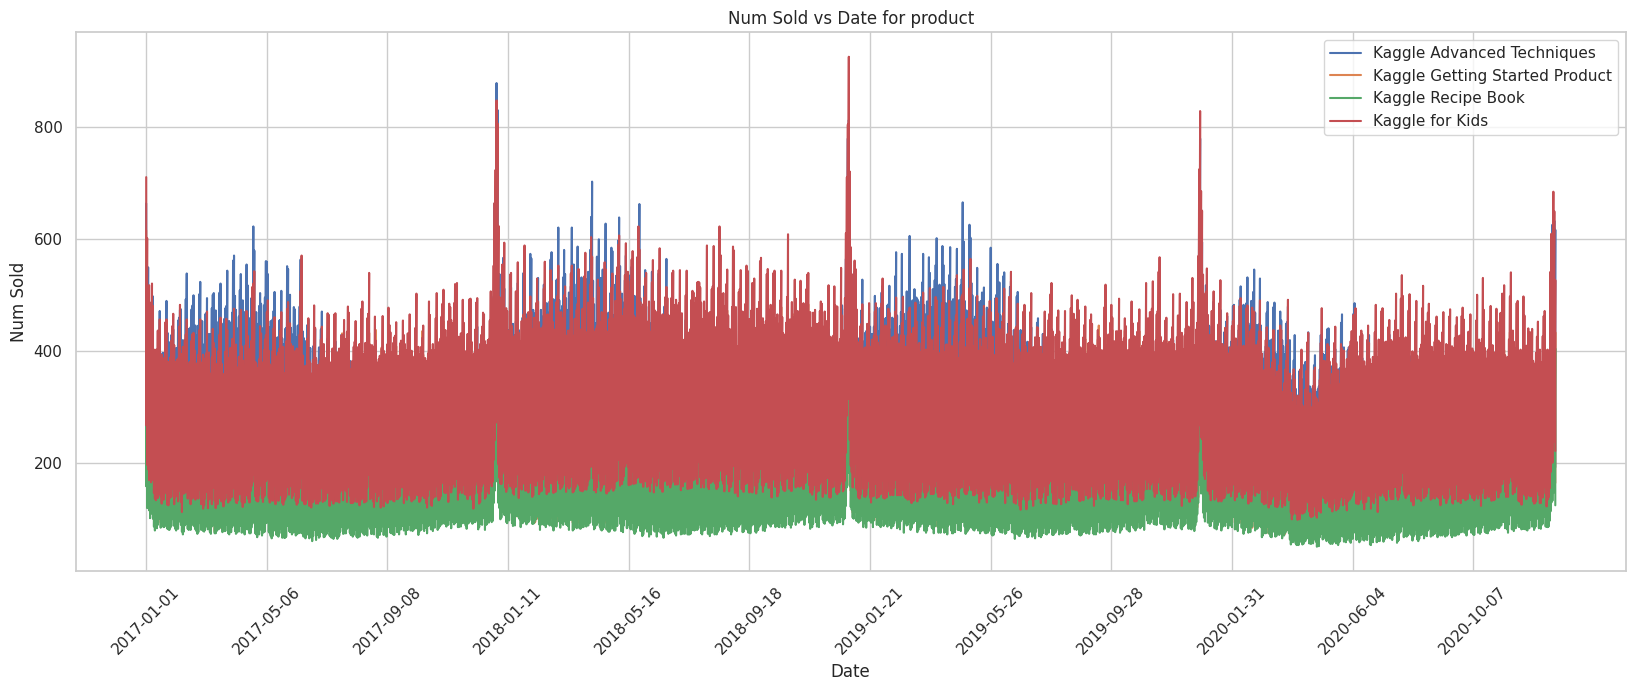

In [18]:
# Filter data for product
kaggle_advanced_techniques_product = df[df['product'] == 'Kaggle Advanced Techniques']
kaggle_getting_started_product = df[df['product'] == 'Kaggle Getting Started']
kaggle_recipe_book_product = df[df['product'] == 'Kaggle Recipe Book']
kaggle_for_kids_product = df[df['product'] == 'Kaggle for Kids: One Smart Goose']

# Plotting the data
plt.figure(figsize=(20, 7))

plt.plot(kaggle_advanced_techniques_product['date'], kaggle_advanced_techniques_product['num_sold'], label='Kaggle Advanced Techniques')
plt.plot(kaggle_getting_started_product['date'], kaggle_getting_started_product['num_sold'], label='Kaggle Getting Started Product')
plt.plot(kaggle_recipe_book_product['date'], kaggle_recipe_book_product['num_sold'], label='Kaggle Recipe Book')
plt.plot(kaggle_for_kids_product['date'], kaggle_for_kids_product['num_sold'], label='Kaggle for Kids')

plt.title('Num Sold vs Date for product')
plt.xlabel('Date')
plt.ylabel('Num Sold')

n = 1000  # Change this value according to your preference
plt.xticks(df['date'][::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

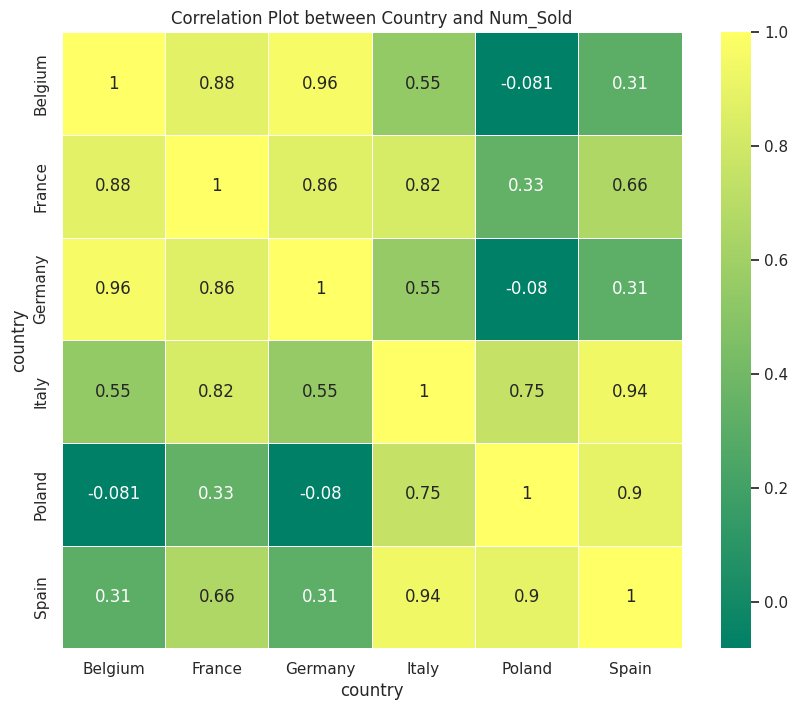

In [19]:
# Group by 'date' and 'country', summing up 'num_sold'
grouped_df = df_train.groupby(['date', 'country'])['num_sold'].sum().reset_index()

# Create a pivot table for 'date' and 'country'
pivot_df = grouped_df.pivot(index='date', columns='country', values='num_sold')

# Calculate correlation matrix
correlation_matrix = pivot_df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='summer', linewidths=.5)
plt.title('Correlation Plot between Country and Num_Sold')
plt.show()

## **Choosing sample data for training**
---

In [20]:
df = train[(train['country']=='Belgium')&(train['product']=='Kaggle Advanced Techniques')&(train['store']=='KaggleMart')]

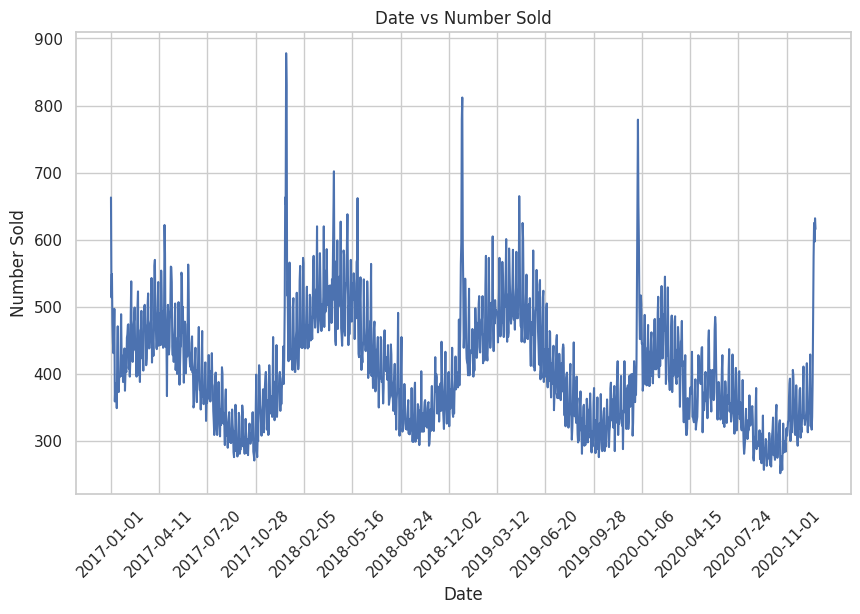

In [21]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plotting the line plot
plt.plot(df['date'], df['num_sold'], linestyle='-')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Date vs Number Sold')

# Display only every nth date on the x-axis
n = 100  # Change this value according to your preference
plt.xticks(df['date'][::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

* A deep copy of the original dataset is created and the column data is altered to appropriate date-time format
* The dataset is then resampled and it is arranged in weekly format. By doing this, the dataset size is reduced and it produces smoother line. The aggregated function used in this case is avg().

In [22]:
df1 = df[['date','num_sold']].copy(deep = True)
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date',inplace = True)
df1 = df1.resample('W').mean()
df1.head()

,num_sold
date,
2017-01-01,663.000000
2017-01-08,480.285714
2017-01-15,393.857143
2017-01-22,409.000000
2017-01-29,417.714286


Min-Max normalization is applied which is a common technique used to scale and normalize features in a dataset. The purpose of scaling is to scale all the datapoints of features or time series variables to a similar scale in this case in the range of 0-1. This can be particularly important for machine learning algorithms, as many of them perform better when the input features are on a similar scale.

In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df1[['num_sold']])

print(scaled_data[:10])

[[1.        ]
 [0.52804428]
 [0.30479705]
 [0.34391144]
 [0.36642066]
 [0.38339483]
 [0.44833948]
 [0.46457565]
 [0.45867159]
 [0.42287823]]


In [24]:
df1['num_sold'] = scaled_data
df1.head()

,num_sold
date,
2017-01-01,1.000000
2017-01-08,0.528044
2017-01-15,0.304797
2017-01-22,0.343911
2017-01-29,0.366421


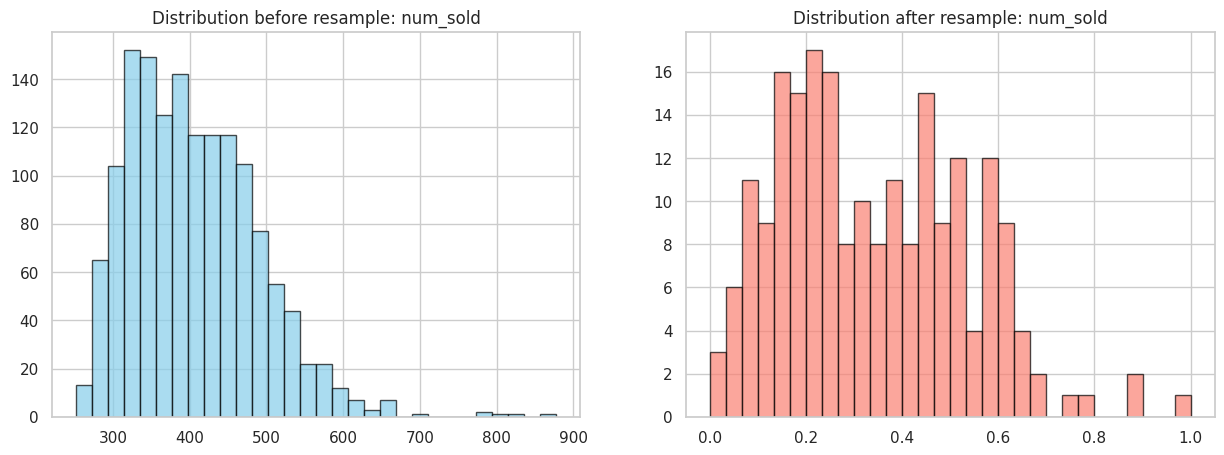

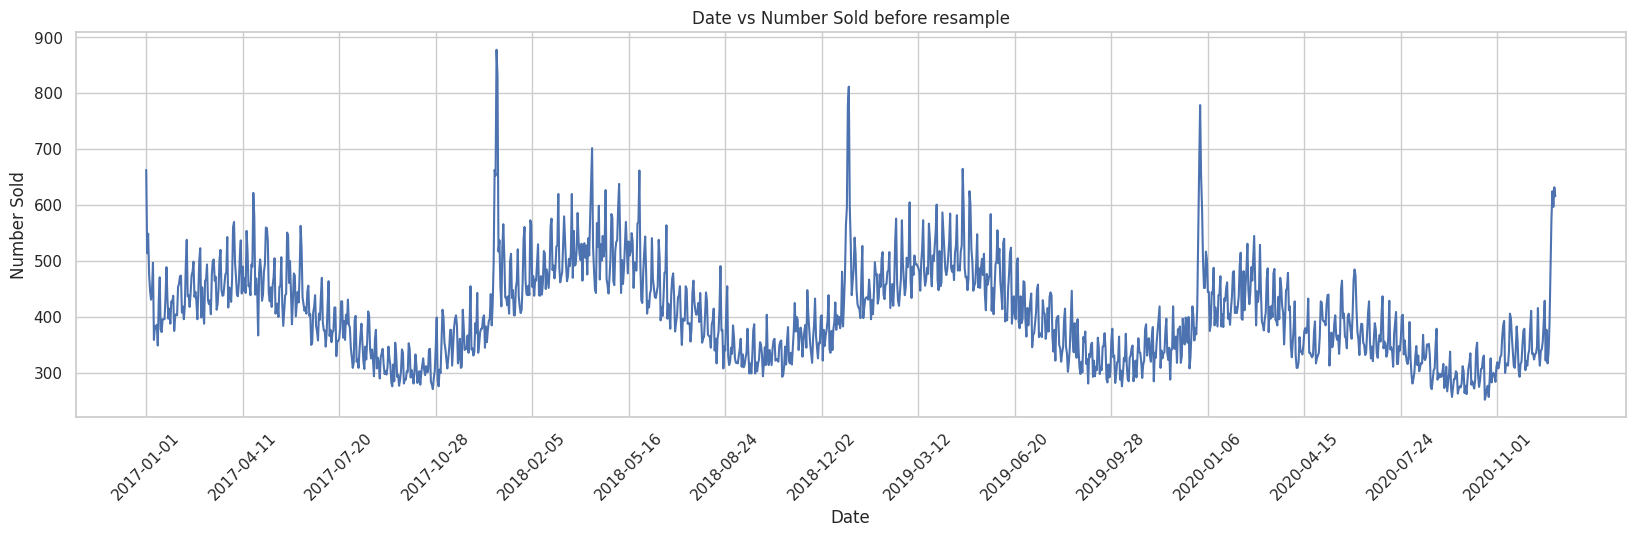

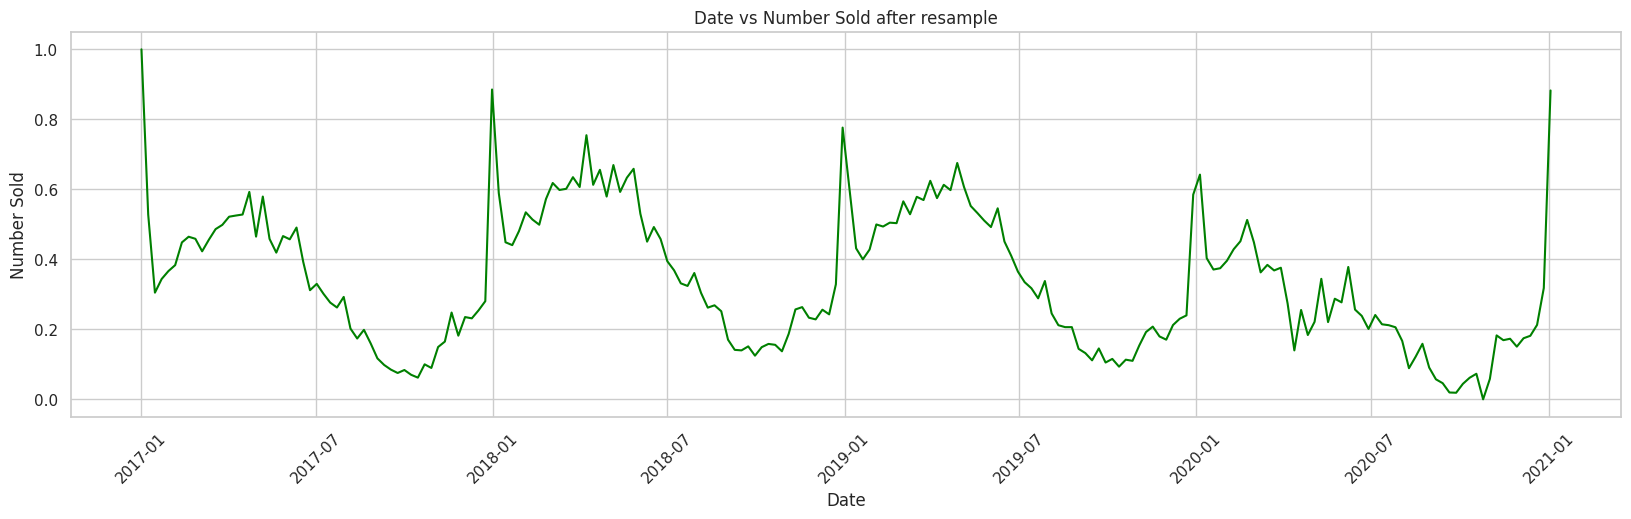

In [25]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.hist(df['num_sold'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution before resample: num_sold')

# Second subplot
plt.subplot(1, 2, 2)
plt.hist(df1['num_sold'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Distribution after resample: num_sold')

# Create a new figure for the line plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

# Plotting the line plot
plt.plot(df['date'], df['num_sold'], linestyle='-')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Date vs Number Sold before resample')

# Display only every nth date on the x-axis
n = 100  # Change this value according to your preference
plt.xticks(df['date'][::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Create a new figure for the line plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

# Plotting the line plot
plt.plot(df1.index, df1['num_sold'], color='green', linestyle='-', markersize=8)
# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Date vs Number Sold after resample')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plots
plt.show()

# Adjust layout
fig.tight_layout(pad=2)

* Distribution of dataset before resampled is pretty much right skewed and distribution od dataset of the resampled displays quite right skewed distribution curve as well.
* It can be clearly observed that there is repetitive slope which indicates seasonality of this dataset
* The number sold rises around the first and second quarter and drops around the third and fourth quarter every year.
* There is a significant spike when reaching new year period between the end of December and beginning of January.

## **Creating a function to test stationarity**
---

In [26]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## **Components of Time Series**
---

A time series can be decomposed into several components, each representing a different aspect or pattern within the data. The main components of a time series are typically:

* Trend: Long-term movement or direction in data. It depicts the underlying pattern that reveals whether the values are rising, falling, or keeping relatively stable over time. A good example of trend is a dataset that visualizes year on year rising temperature of the Earth due to Global Warming

* Seasonality: The repeated and predictable pattern that appears at regular intervals throughout the time series. Seasonality is commonly associated with repeating cycles, such as daily, weekly, monthly, or annual patterns. A good example of seasonality is sale of jackets and sweaters specifically in the winter season or sale of product in specific events or big holiday in certain country.


* Cycle: Cyclical patterns that are not strictly periodic, such as seasonality, but yet show some consistency over a longer time period. Cycles are related with economic, business, or natural cycles, and their durations might vary. It appears usually in the Business Quarters i.e Q1, Q2, Q3 & Q4.

* Irregular/Residual: Random and unpredictable fluctuations or noise in a time series that are not explained by trend, seasonality, or cycles. The residual component accounts for unexplained variability and measurement errors. It presents in the occurence of natural disaster or global pandemic.

## Seasonal decompose
---

* function seasonal_decompose from the statsmodel library is used to decompose a time series into its trend, seasonal, and residual components. The decomposition is then plotted.
* This function has a parameter, model, that needs to be assigned the value additive or multiplicative.
    * Additive Model : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    * Multiplicative Model : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

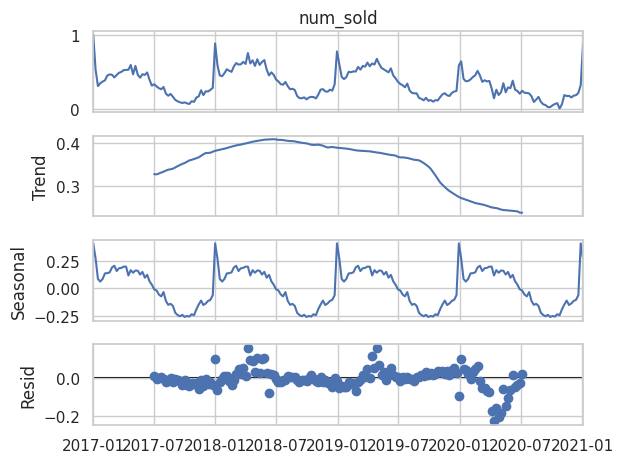

In [28]:
dec = sm.tsa.seasonal_decompose(df1['num_sold'], model = 'additive').plot()
plt.show();

Conclusion from graph above:
* Data has a non-linear uptrend.
* A seasonal pattern is present in the data.
* The Residual plot is the plot that describes the data if the trend and seasonal components of the data are completely eliminated.

## **Stationarity**
---

Stationarity is a concept in time series analysis. A time series is considered to be stationary if its statistical features, such as mean, variance, and autocorrelation, remain constant across time. Simply put, a stationary time series has a stable and constant behavior throughout its history.

Features in a time series are time-dependent, they are a function of time. Statistical parameters' values fluctuate over time when they are extracted from characteristics. If the time series is not stationary, the forecasts diverge from the original values, increasing the inaccuracy because we do not know how the statistical parameters change with time. Thus, by keeping time series stable, we effectively eliminate the effects of statistical factors on the forecast.


Augmented Dickey Fuller (ADF) Test is typically used to test stationarity. Stationarity is an important notion in time series analysis, and a stationary time series simplifies the modeling process and improves the results' reliability. The null hypothesis for the ADF test is that the time series has a unit root, suggesting that it is not stationary. The alternative hypothesis is that the time series remains stationary after differencing.
    
Output of the Augmented Dickey Fuller Test include :
* Test Statistic: The test statistic indicates how many standard deviations the series is from being stationary. The more negative the test statistic, the greater the evidence for the absence of a unit root (non-stationarity). A more negative test statistic indicates a greater possibility of stationarity.
* p-value: The p-value corresponds to the null hypothesis that the time series has a unit root. A low p-value (usually less than a predetermined significance level, such as 0.05) implies that you can reject the null hypothesis. In this case, rejecting the null hypothesis is advantageous, implying that the time series is stationary. A high p-value indicates that there is insufficient evidence to reject the null hypothesis of non-stationarity.
* #Lags Used: The number of lags included in the regression model. The ADF test frequently includes lagged time series differences to detect autocorrelation.
* Number of Observations Used: These values indicate the number of observations utilized in the test, as well as the critical values associated with various confidence levels. Statistical significance is determined by comparing the critical values to the test statistic.
* Critical Value: Critical values are thresholds used to assess whether to reject the null hypothesis. If the absolute value of the test statistic exceeds the critical value at a specified significance level (e.g., 1%, 5%, or 10%), the null hypothesis is rejected. The crucial values depend on the significance level chosen.

There are 2 requirements for the Null Hypothesis to be rejected and accepting that the time series is stationary:
* Critical Value (5%) > Test Statistic
* p-value < 0.05

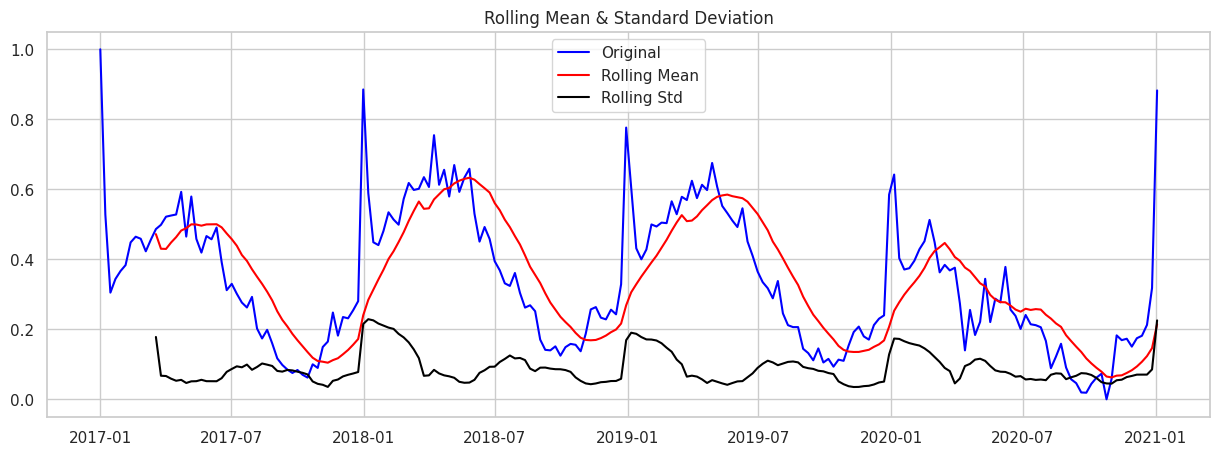

Results of Dickey-Fuller Test:
Test Statistic                  -4.424946
p-value                          0.000268
#Lags Used                      12.000000
Number of Observations Used    197.000000
Critical Value (1%)             -3.463987
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
dtype: float64


In [29]:
test_stationarity(df1['num_sold'])

## **Conclusion**
---

* Rolling Mean is clearly variable with time. It is very close to the data which can be a good descriptor of the data and Rolling Standard Deviation is quite consistent
* Test Statistic : (-4.42) > Critical Value (5%) : (-2.87)
* p-value (0.000268) < 0.05
    
Thus, Null Hypothesis can be rejected and it can concluded that the Number Sold time series is stationary. 

By differencing, or subtracting the previous value from the current value, the trend, seasonality, and stationary nature of the time series can be erased.

In [30]:
df2 = df[['date','num_sold']].copy()
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date',inplace = True)
df2 = df2.resample('W').mean()

In [31]:
df2['Log_num_sold'] = np.log(df2['num_sold'])
df2

,num_sold,Log_num_sold
date,,
2017-01-01,663.000000,6.496775
2017-01-08,480.285714,6.174381
2017-01-15,393.857143,5.975988
2017-01-22,409.000000,6.013715
2017-01-29,417.714286,6.034798
...,...,...
2020-12-06,343.428571,5.838979
2020-12-13,346.142857,5.846852
2020-12-20,358.142857,5.880932


In [32]:
df2_log_diff = df2['Log_num_sold'].diff()
df2_log_diff = df2_log_diff.dropna()

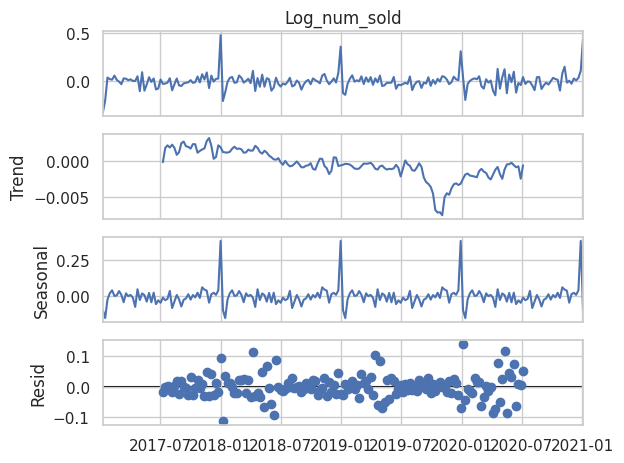

In [33]:
dec = sm.tsa.seasonal_decompose(df2_log_diff,period = 52).plot()
plt.show()

* Tthe log of the data is constructed to deal with stationarity and differencing is done to handle trend and seasonality.
* Trend and Seasonality of the data have flatter line compared with previous graph & their values have been reduced as well.

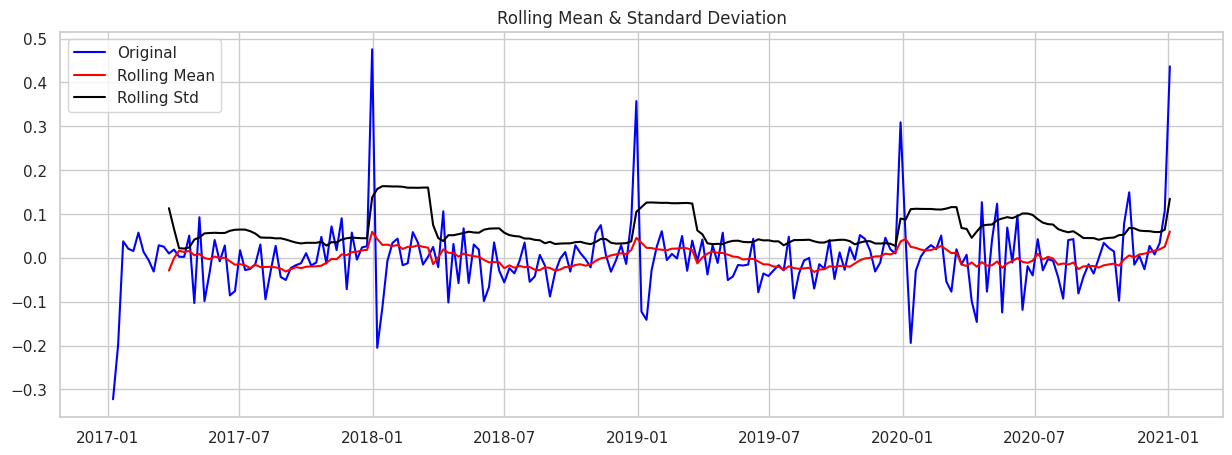

Results of Dickey-Fuller Test:
Test Statistic                  -2.635423
p-value                          0.085895
#Lags Used                       7.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


In [34]:
test_stationarity(df2_log_diff)

## **Conclusion**
---
* Rolling Mean is very close to 0 with very small variations are present.
* Rolling Standard Deviation is very close to 0.01 with some crests and troughs present throughout.
* Critical Value (5%) : (-2.87) > Test Statistic : (-2.63). We can say that the time series is stationary with 99% confidence as the Test Statistic is less than Critical Value (1%).
* 0.05 < p-value (0.085)

The Test Statistic (-2.63) is more than the critical value 1% (-3.46) and the p-value (0.085) is more than 0.05. From these outputs,the Null Hypothesis can not be rejected and the Alternate Hypothesis can be accepted i.e the above time series is not stationary. So, this technique is not succesful to make the dataset stationary.

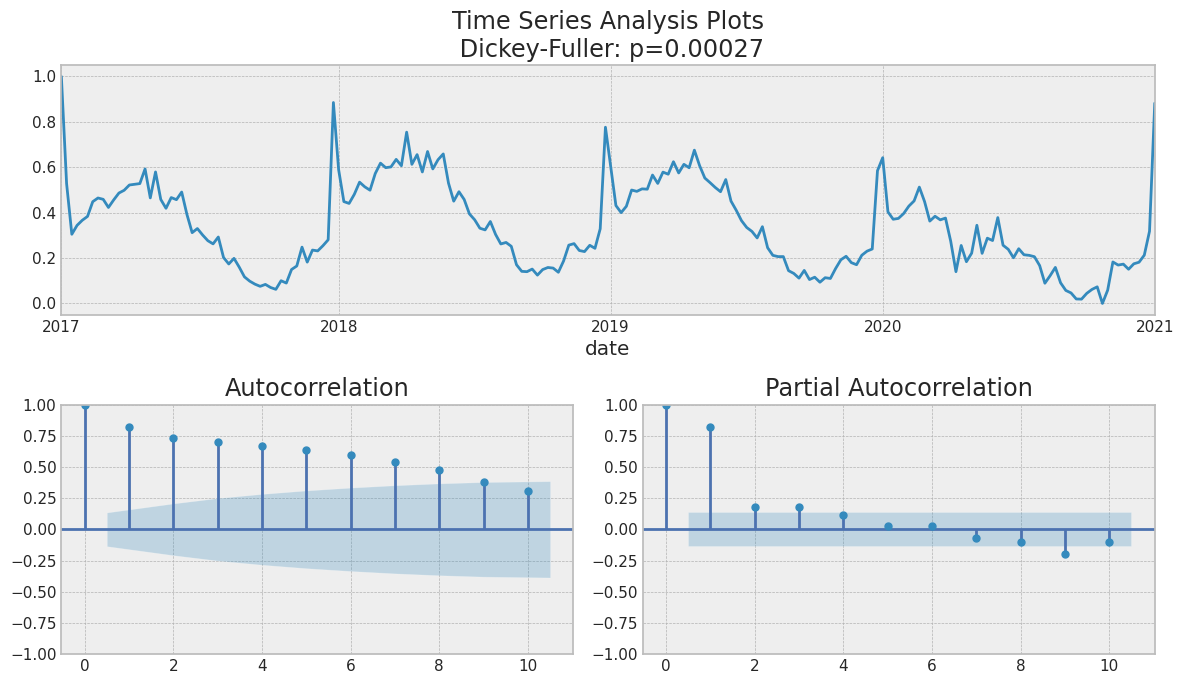

In [35]:
tsplot(df1['num_sold'],lags = 10)

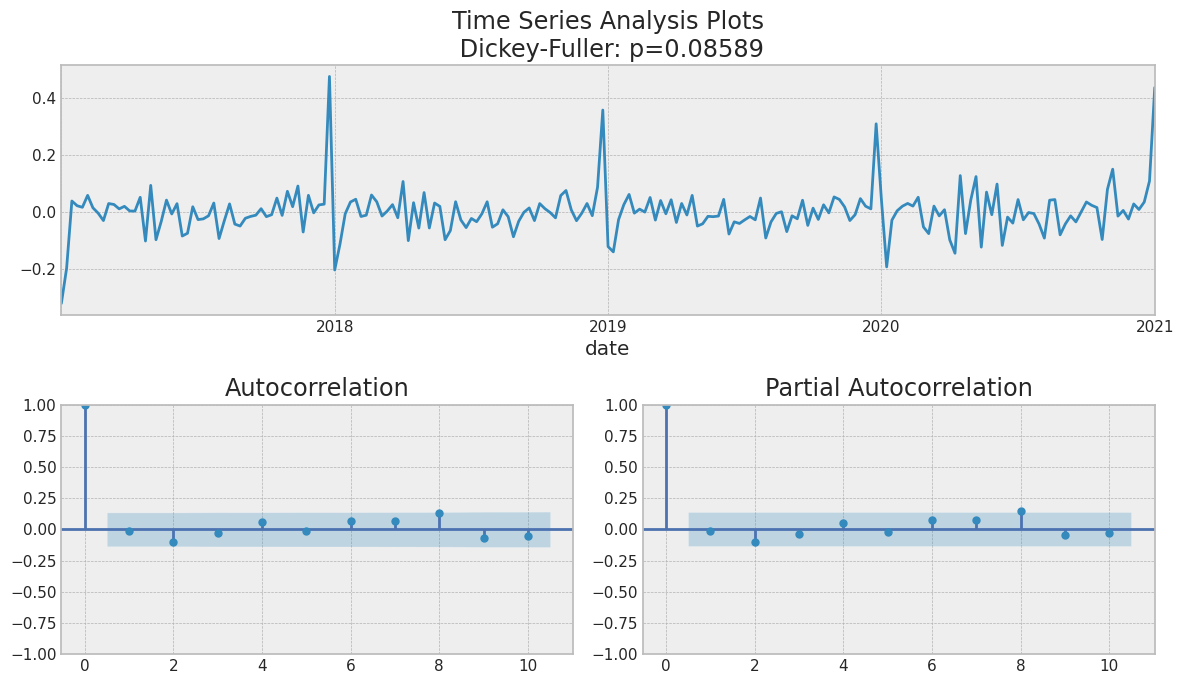

In [36]:
tsplot(df2_log_diff,lags = 10)

# **Building the Model**
---

The following basic steps can be taken to model in scalecast:

1. **Specify a Test Length**: In time series modeling, it is usual to assess a model's performance on a different test set that was not utilized during training. This phase entails setting aside a subset of the time series data for testing. The test length is the number of last observations in the entire time series that will be used for testing. This is crucial to determine how effectively the model generalizes to new data. The set_test_length function is mentioned, which allows to set the test length. A discrete number can be specified reflecting the number of observations or a percentage of the total number of observations in the time series.

2. **Generate Future Dates**: After storing the test set, the following step is to create future dates for forecasting. Scalecast's models provide forecasts that extend into the future, and the number of dates you enter in this phase defines how far into the future all models will deliver projections. The generated future dates enable you define the time period for which you desire predictions. Depending on the forecasting horizon interest, there is a need to generate a large number of future dates.

3. **Choose an Estimator**: In time series forecasting, the term "estimator" refers to the precise forecasting algorithm or model that will be applied. The "lstm" (Long Short-Term Memory) estimator is ued. Tt is a kind recurrent neural network (RNN) that is extensively used for sequence modeling and time series forecasting. Estimators could include other techniques like ARIMA, Exponential Smoothing, or other machine learning models designed for time series forecasting.

4. **Evaluating Cofidence Intervals**: The eval_cis method is used to evaluate confidence intervals for the forecasts. mode=True indicates that the confidence intervals are calculated in a mode-based approach. cilevel=0.95 specifies the confidence level (95%).


In [37]:
f = Forecaster(y=df1.num_sold,current_dates=df1.index)

# f.set_test_length(12)     
# f.generate_future_dates(90) 

f.set_test_length(0.3) # 30% test set
f.generate_future_dates(90)

f.set_estimator('lstm')
f.eval_cis(mode=True, cilevel=0.95)

## **Identifying Pattern**
---

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are visual tools used in time series analysis to comprehend and recognize autocorrelation patterns in data. Autocorrelation quantifies the relationship between a time series and its lag values. ACF and PACF charts assist in understanding the order of AutoRegressive (AR) and Moving Average (MA) components in a time series model, which is critical for models such as ARIMA (AutoRegressive Integrated Moving Average).

* Autocorrelation Function (ACF): The ACF calculates the correlation between a time series and its lag values. It demonstrates how well the current value of the time series correlates with its prior values at various lags. It typically displays a bar chart with the autocorrelation coefficients for various lags. The x-axis shows the lag, while the y-axis displays the autocorrelation coefficient. Patterns in the ACF plot assist in identifying seasonality and possibly autoregressive components in the data. For example, a big increase at a lag of 7 in a daily time series could indicate weekly seasonality.

* Partial Autocorrelation Function (PACF): The PACF calculates the correlation between a time series and its lagged values while accounting for the influence of intermediate lags. In other words, it displays the correlation between current and past values after removing the effects of intermediate lags. Patterns in the PACF plot assist in determining the order of the autoregressive component in the data. For example, a substantial increase at lag 1 and a drop-off at latency 2 indicates an AutoRegresive of order 1 process.

Interpreting ACF and PACF plots involves looking for significant spikes or patterns. Common guidelines include:

* Significant spikes at regular intervals in the ACF plot may indicate seasonality.
* Significant spikes at specific lags in the PACF plot may suggest the order of the autoregressive component.

ACF and PACF plots are often used as a guide to select the model parameters (p, d, q) in the ARIMA modeling, where:

* p -> the order of the autoregressive component.
* d -> the differencing order.
* q -> the order of the moving average component.

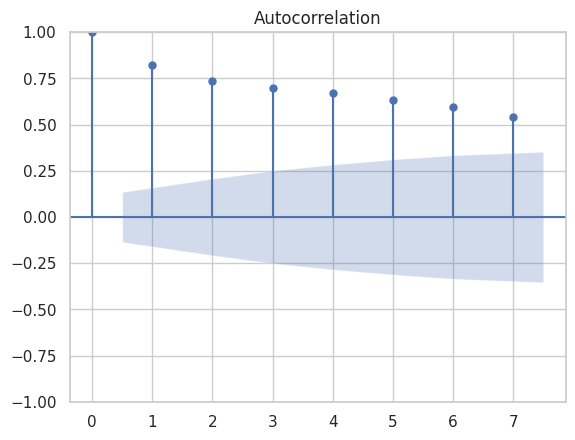

In [38]:
f.plot_acf(lags=7)
plt.show()

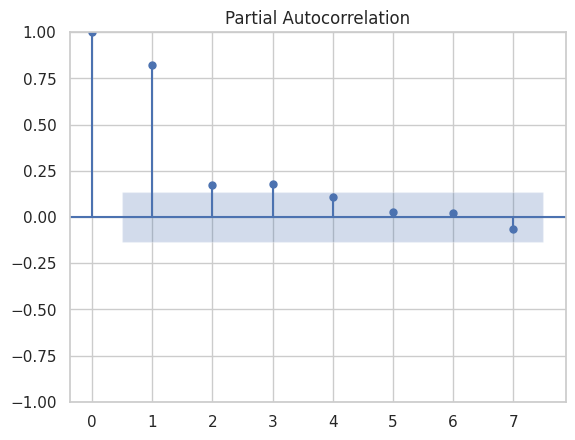

In [39]:
f.plot_pacf(lags=7)
plt.show()

## **Long Short-Term Memory**
---

4/4 [==============================] - 0s 3ms/step


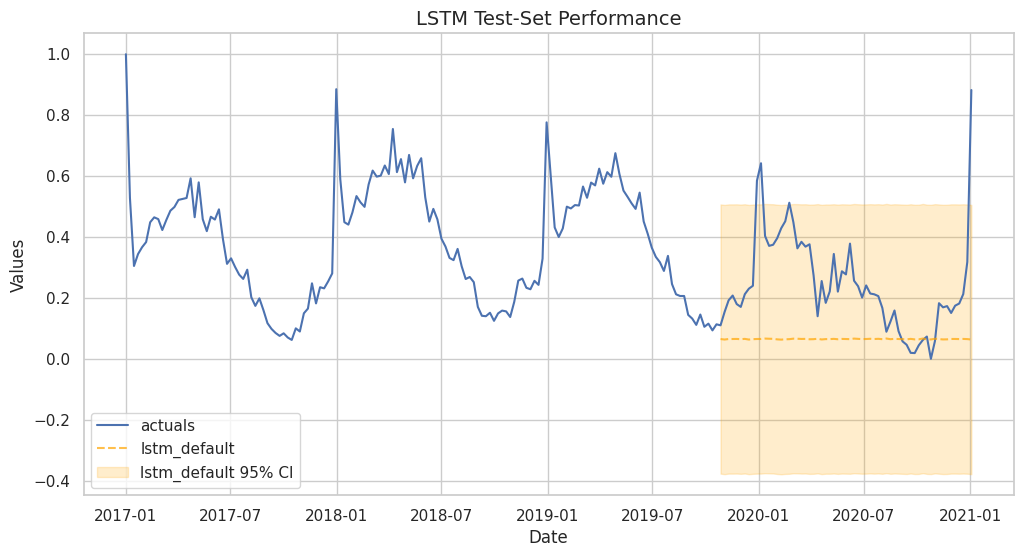

In [40]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(models='lstm_default',ci=True)
plt.title('LSTM Test-Set Performance',size=14)
plt.show()

In [41]:
f.manual_forecast(call_me='lstm_30lags',lags=30)

3/3 [==============================] - 0s 6ms/step


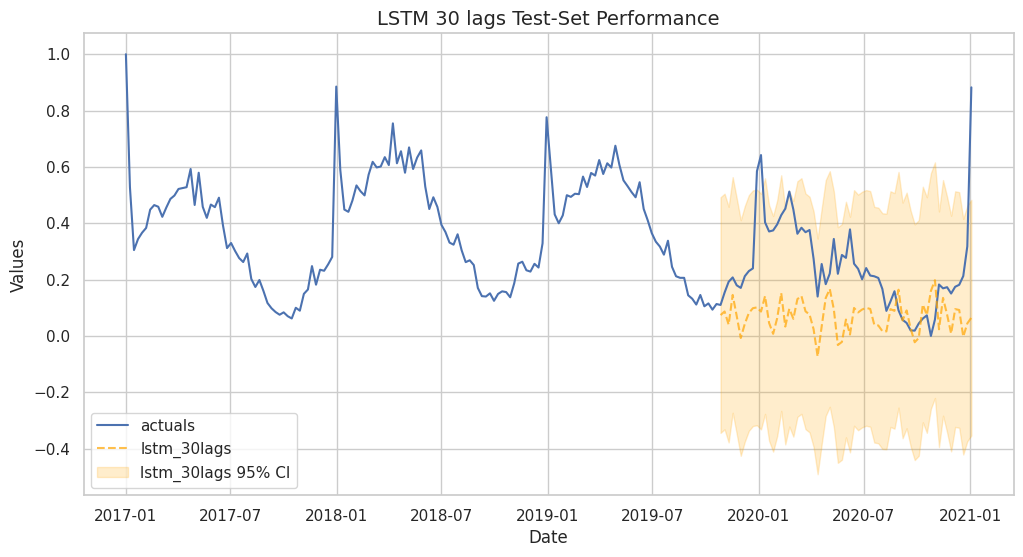

In [42]:
f.plot_test_set(models='lstm_30lags',ci=True)
plt.title('LSTM 30 lags Test-Set Performance',size=14)
plt.show()

In [43]:
f.manual_forecast(call_me='lstm_7lags_5epochs',
                  lags=24,
                  epochs=5,
                  validation_split=.2,
                  shuffle=True)

Epoch 1/5
2/2 [==============================] - 3s 603ms/step - loss: 0.3614 - val_loss: 0.3259
Epoch 2/5
2/2 [==============================] - 0s 45ms/step - loss: 0.3581 - val_loss: 0.3217
Epoch 3/5
2/2 [==============================] - 0s 44ms/step - loss: 0.3548 - val_loss: 0.3174
Epoch 4/5
2/2 [==============================] - 0s 43ms/step - loss: 0.3515 - val_loss: 0.3132
Epoch 5/5
1/1 [==============================] - 0s 437ms/step
Epoch 1/5
3/3 [==============================] - 3s 282ms/step - loss: 0.3735 - val_loss: 0.2986
Epoch 2/5
3/3 [==============================] - 0s 29ms/step - loss: 0.3676 - val_loss: 0.2939
Epoch 3/5
3/3 [==============================] - 0s 30ms/step - loss: 0.3617 - val_loss: 0.2891
Epoch 4/5
3/3 [==============================] - 0s 27ms/step - loss: 0.3558 - val_loss: 0.2842
Epoch 5/5
3/3 [==============================] - 0s 6ms/step


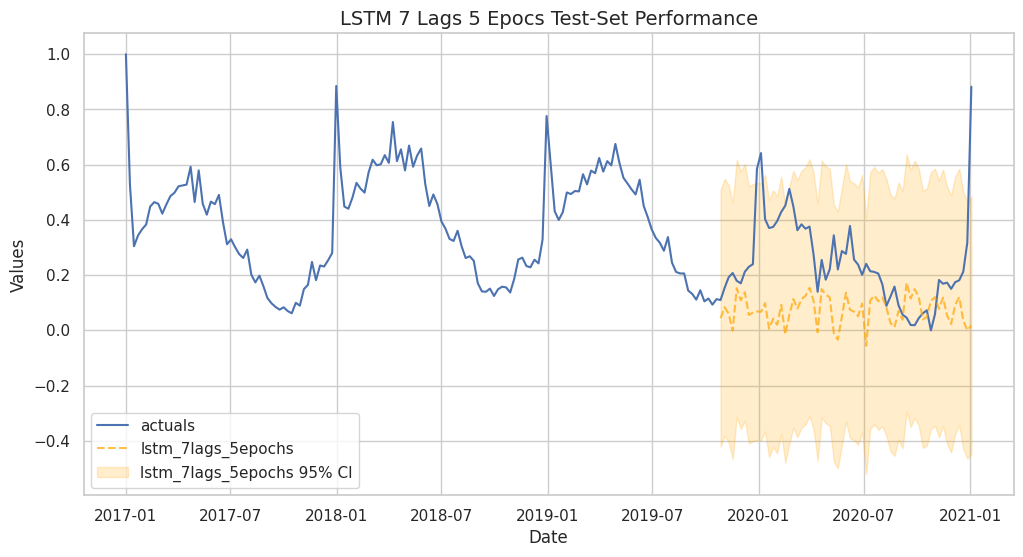

In [44]:
f.plot_test_set(models='lstm_7lags_5epochs',ci=True)
plt.title('LSTM 7 Lags 5 Epocs Test-Set Performance',size=14)
plt.show()

In [45]:
f.manual_forecast(call_me='lstm_30lags_earlystop_8layers',
                  lags=30,
                  epochs=50,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))

Epoch 1/50
2/2 [==============================] - 8s 1s/step - loss: 0.3594 - val_loss: 0.3099
Epoch 2/50
2/2 [==============================] - 0s 79ms/step - loss: 0.3547 - val_loss: 0.3041
Epoch 3/50
2/2 [==============================] - 0s 77ms/step - loss: 0.3491 - val_loss: 0.2988
Epoch 4/50
2/2 [==============================] - 0s 73ms/step - loss: 0.3424 - val_loss: 0.2932
Epoch 5/50
2/2 [==============================] - 0s 79ms/step - loss: 0.3345 - val_loss: 0.2880
Epoch 6/50
2/2 [==============================] - 0s 79ms/step - loss: 0.3259 - val_loss: 0.2839
Epoch 7/50
2/2 [==============================] - 0s 74ms/step - loss: 0.3168 - val_loss: 0.2788
Epoch 8/50
2/2 [==============================] - 0s 74ms/step - loss: 0.3082 - val_loss: 0.2725
Epoch 9/50
2/2 [==============================] - 0s 81ms/step - loss: 0.2999 - val_loss: 0.2653
Epoch 10/50
2/2 [==============================] - 0s 76ms/step - loss: 0.2921 - val_loss: 0.2580
Epoch 11/50
2/2 [==============

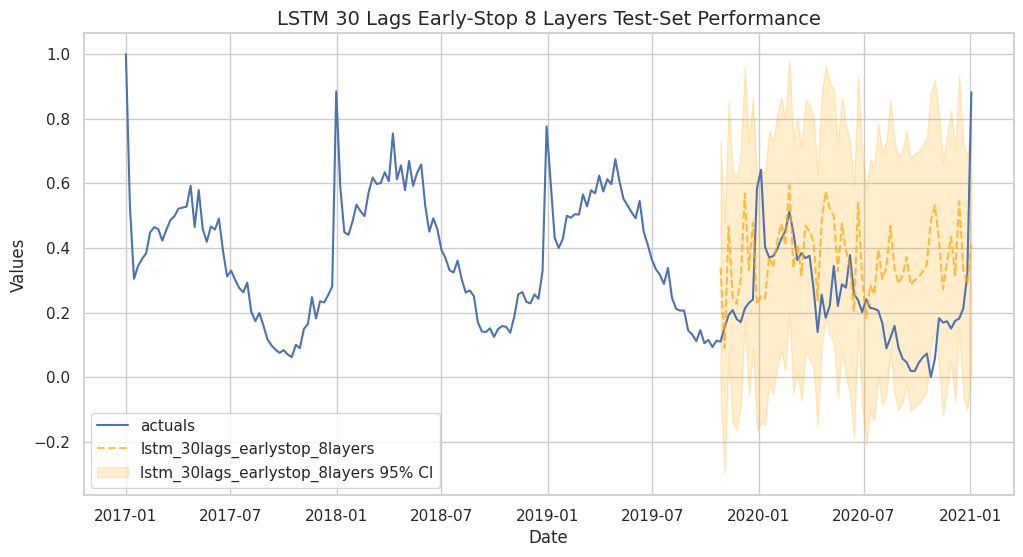

In [46]:
f.plot_test_set(models='lstm_30lags_earlystop_8layers',ci=True)
plt.title('LSTM 30 Lags Early-Stop 8 Layers Test-Set Performance',size=14)
plt.show()

Epoch 1/15
2/2 [==============================] - 11s 2s/step - loss: 0.3688 - val_loss: 0.2928
Epoch 2/15
2/2 [==============================] - 0s 111ms/step - loss: 0.3515 - val_loss: 0.2585
Epoch 3/15
2/2 [==============================] - 0s 117ms/step - loss: 0.3131 - val_loss: 0.2581
Epoch 4/15
2/2 [==============================] - 0s 117ms/step - loss: 0.2682 - val_loss: 0.2675
Epoch 5/15
2/2 [==============================] - 0s 116ms/step - loss: 0.2457 - val_loss: 0.2459
Epoch 6/15
2/2 [==============================] - 0s 118ms/step - loss: 0.2136 - val_loss: 0.2341
Epoch 7/15
2/2 [==============================] - 0s 116ms/step - loss: 0.2024 - val_loss: 0.2313
Epoch 8/15
2/2 [==============================] - 0s 117ms/step - loss: 0.1906 - val_loss: 0.2320
Epoch 9/15
2/2 [==============================] - 0s 115ms/step - loss: 0.1805 - val_loss: 0.2302
Epoch 10/15
2/2 [==============================] - 0s 116ms/step - loss: 0.1759 - val_loss: 0.2280
Epoch 11/15
2/2 [====

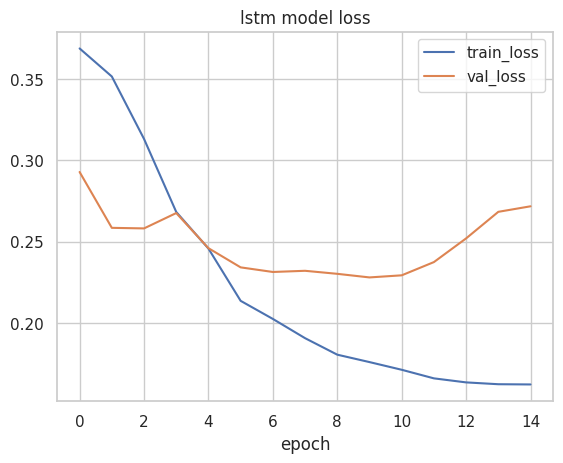

Epoch 1/15
3/3 [==============================] - 11s 1000ms/step - loss: 0.3667 - val_loss: 0.2649
Epoch 2/15
3/3 [==============================] - 0s 108ms/step - loss: 0.3196 - val_loss: 0.2153
Epoch 3/15
3/3 [==============================] - 0s 106ms/step - loss: 0.2663 - val_loss: 0.2186
Epoch 4/15
3/3 [==============================] - 0s 110ms/step - loss: 0.2273 - val_loss: 0.1731
Epoch 5/15
3/3 [==============================] - 0s 99ms/step - loss: 0.1954 - val_loss: 0.1656
Epoch 6/15
3/3 [==============================] - 0s 103ms/step - loss: 0.1793 - val_loss: 0.1726
Epoch 7/15
3/3 [==============================] - 0s 103ms/step - loss: 0.1655 - val_loss: 0.1718
Epoch 8/15
3/3 [==============================] - 0s 103ms/step - loss: 0.1589 - val_loss: 0.1642
Epoch 9/15
3/3 [==============================] - 0s 103ms/step - loss: 0.1568 - val_loss: 0.1614
Epoch 10/15
3/3 [==============================] - 0s 106ms/step - loss: 0.1565 - val_loss: 0.1573
Epoch 11/15
3/3 [=

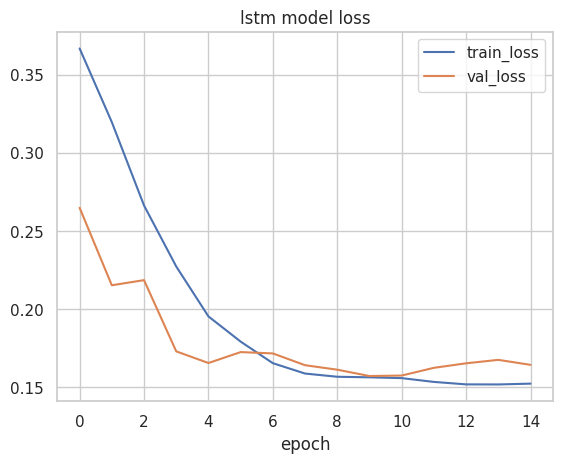

In [47]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

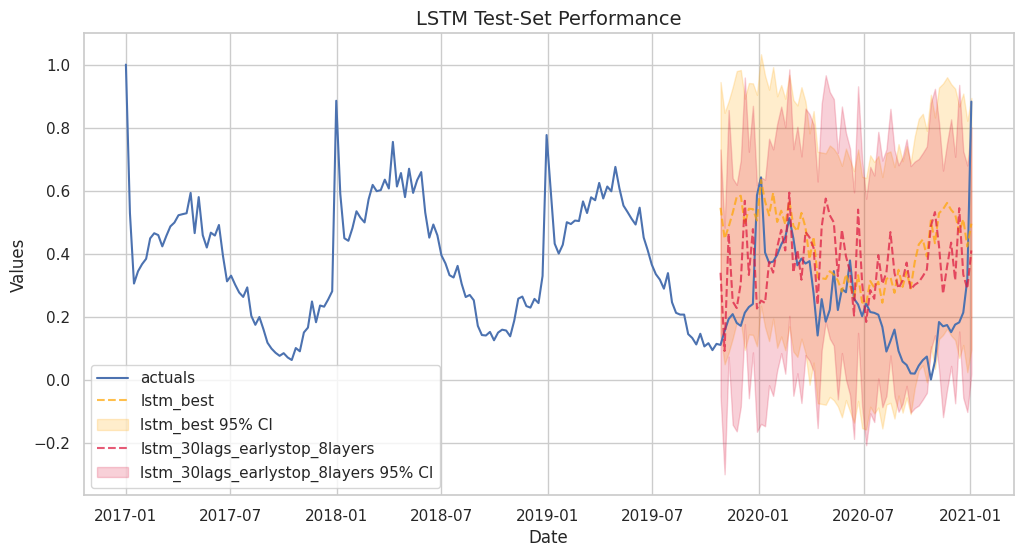

In [48]:
f.plot_test_set(order_by='TestSetMAPE',models='top_2',ci=True)
plt.title('LSTM Test-Set Performance',size=14)
plt.show()

## **Multiple Linear Regression**
---

In [49]:
f.set_estimator('mlr') 
f.add_ar_terms(7) 
f.add_seasonal_regressors('month','quarter',dummy=True) 
f.add_seasonal_regressors('year') 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

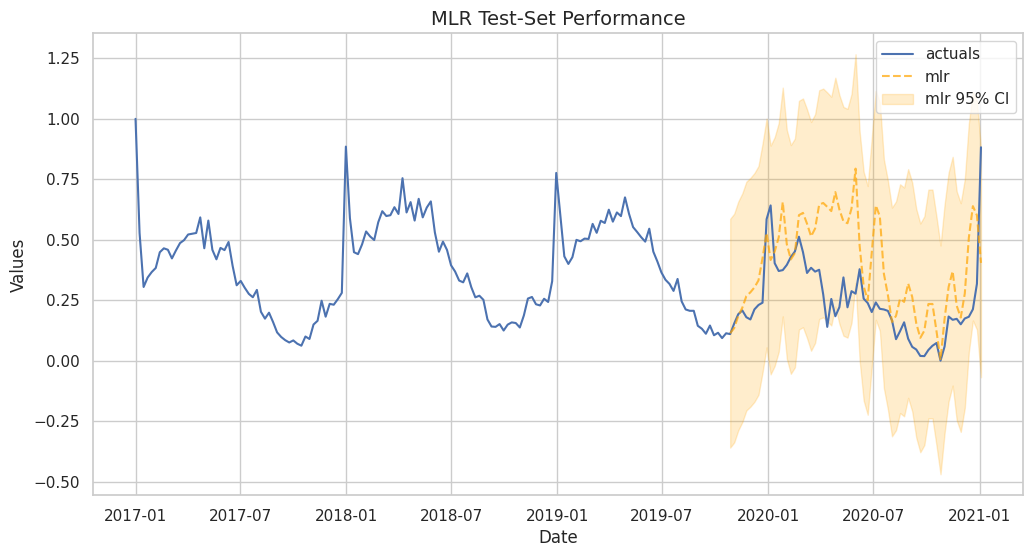

In [50]:
f.manual_forecast(call_me='mlr')
f.plot_test_set(models='mlr', ci=True)
plt.title('MLR Test-Set Performance',size=14)
plt.show()

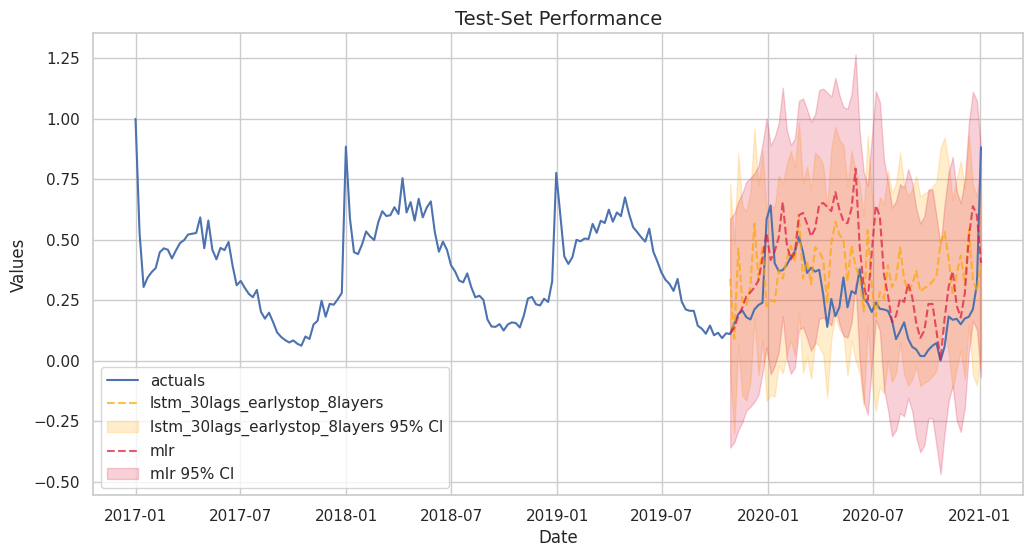

In [51]:
f.manual_forecast()
f.plot_test_set(ci=True, order_by='TestSetRMSE',models='top_2')
plt.title('Test-Set Performance',size=14)
plt.show()

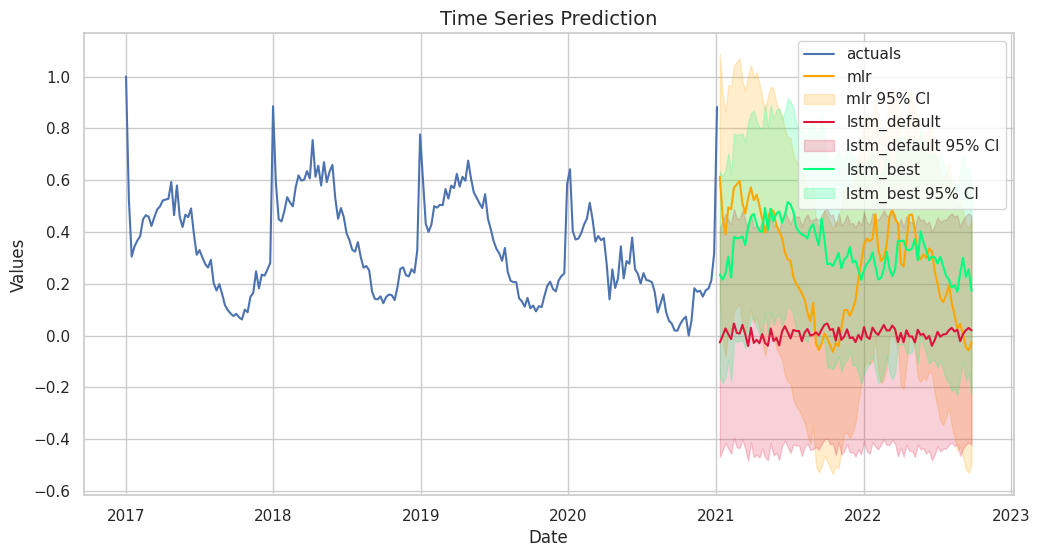

In [52]:
f.plot(models=['mlr','lstm_best', 'lstm_default'],
       order_by='TestSetR2',
       ci=True)
plt.title('Time Series Prediction',size=14)
plt.show()

# **Model Summary**
---

In [53]:
model_summary = f.export('model_summaries', determine_best_by='TestSetRMSE')[
                         ['ModelNickname',
                          'TestSetMAPE',
                          'TestSetRMSE',
                          'TestSetR2',
                          'best_model']]

model_summary.head(10)

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model
0,lstm_30lags_earlystop_8layers,NaN,0.222234,-0.943296,True
1,mlr,NaN,0.227217,-1.031418,False
2,lstm_default,NaN,0.240183,-1.269876,False
3,lstm_30lags,NaN,0.240425,-1.274466,False
4,lstm_best,NaN,0.243190,-1.327076,False
5,lstm_7lags_5epochs,NaN,0.245349,-1.368571,False


In [54]:
# Use rank() to create a new column 'rank'
model_summary['rank'] = model_summary['TestSetRMSE'].rank(ascending=True)
model_summary

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model,rank
0,lstm_30lags_earlystop_8layers,NaN,0.222234,-0.943296,True,1.0
1,mlr,NaN,0.227217,-1.031418,False,2.0
2,lstm_default,NaN,0.240183,-1.269876,False,3.0
3,lstm_30lags,NaN,0.240425,-1.274466,False,4.0
4,lstm_best,NaN,0.243190,-1.327076,False,5.0
5,lstm_7lags_5epochs,NaN,0.245349,-1.368571,False,6.0


# **Conclusion**
---

* This is a great dataset for understanding Time Series Forecasting Analysis problems which provides opportunity to explore multiple concepts.
* EDA section provides great insights which is really helpful for data analysis, data exploration, and generating data-driven decision for business purposes.
* The time series analysis, stationarity, plotting, transforming, and model selecting have been performed in this notebook. However, it still opens for discussion and further improvement.
* For future improvement of this notebook, other model can be explored and implemented.

# **References**
---
* [Tubular Playground Series Dataset](https://www.kaggle.com/competitions/tabular-playground-series-sep-2022)
* [Avocado Price Forecast ARIMA - SARIMA](https://www.kaggle.com/code/tanmay111999/avocado-price-forecast-arima-sarima-detailed#Modeling)
* [Intro to LSTM Time Series](https://www.kaggle.com/code/azminetoushikwasi/intro-to-lstm-time-series-forecasting/notebook#%E2%8F%B3-9.-Comparing-Models)
* [Stock Market Analysis Prediction Using LSTM](https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm#4.-What-was-the-correlation-between-different-stocks-closing-prices)
* [Scalecast Library Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html)
* [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Exploring the LSTM Neural Network Model for Time Series](https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf)
* [Scalecast](https://github.com/mikekeith52/scalecast?tab=readme-ov-file)